In [1]:
import pickle
import shutil
from concurrent.futures import ProcessPoolExecutor
from pathlib import Path

import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv1D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling1D,
)
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adadelta, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.math import confusion_matrix


In [2]:
#from google.colab import drive

#drive.mount("/content/drive")


Mounted at /content/drive


In [20]:
#!unzip -qq /content/drive/MyDrive/data/images.zip

In [2]:
# constants
# DATA_DIR = Path("/content/drive/MyDrive/data")
# IMG_DIR = Path("/content/images")

DATA_DIR = Path("data")
IMG_DIR = DATA_DIR / "images"
TRAIN_DIR = IMG_DIR / "train"
TEST_DIR = IMG_DIR / "test"
US8K_DIR = DATA_DIR / "UrbanSound8K"
AUDIO_DIR = US8K_DIR / "audio"
META_CSV = US8K_DIR / "metadata" / "UrbanSound8K.csv"
LOG_DIR = DATA_DIR / "logs"
NUM_CLASSES = 10


In [3]:
# hyperparameters
SAMPLING_RATE = 16000  # paper: 16000, other values: 22050, 44100
CHUNK_SIZE = int(1 * SAMPLING_RATE)  # paper: 16000 (i.e. 1 second), others: 0.1 second
OVERLAP_PERCENT = 75  # paper: 75%

# model related
BATCH_SIZE = 100  # paper: 100
EPOCHS = 100  # paper: 100
EARLY_STOP_PATIENCE = 50


In [4]:
# calculated constants
STRIDE = int((1 - OVERLAP_PERCENT / 100) * CHUNK_SIZE)
MODEL_ID = f"Sr{SAMPLING_RATE}Cs{CHUNK_SIZE}Ol{OVERLAP_PERCENT}"
FOLD_DATA_DIR = DATA_DIR / f"foldData.{MODEL_ID}.pickle"
FOLD_DATA = DATA_DIR / f"foldData.{MODEL_ID}.pickle"
MODEL_FILE = DATA_DIR / "saved_models" / f"model.{MODEL_ID}"
MODEL_FILE_2D = DATA_DIR / "2d_saved_models" / f"model.{MODEL_ID}"
VGG_MODEL_FILE = DATA_DIR / "vgg_saved_models" / f"model.{MODEL_ID}"


In [5]:
SAMPLING_RATE, CHUNK_SIZE, STRIDE, FOLD_DATA, MODEL_FILE


(16000,
 16000,
 4000,
 PosixPath('data/foldData.Sr16000Cs16000Ol75.pickle'),
 PosixPath('data/saved_models/model.Sr16000Cs16000Ol75'))

In [6]:
def to_chunks(X, y, chunk_size, stride):
    """Split a numpy array into chunks of given size jumping stride indices each time.
    Any chunks of smaller size are padded with 0 at the end."""
    chunks = []
    for start in range(0, len(X), stride):
        chunk = X[start : start + chunk_size]
        if len(chunk) == chunk_size:
            chunks.append(chunk)
        # take a partially filled chunk only if its size is >= 50% of chunk_size
        # or it is the only chunk present for this input
        # elif (len(chunk) >= 0.5 * chunk_size) or len(chunks) == 0:
        # elif len(chunks) == 0:
        #    chunk = np.pad(chunk, (0, chunk_size - len(chunk)))
        #    chunks.append(chunk)
        #    break
        else:
            break
    if len(chunks) == 0:
        return None
    y = np.repeat(y, len(chunks))
    return np.array(chunks), y, len(chunks)


In [7]:
def load_and_save_fold_data(meta, fold, sr, chunk_size, stride):
    """Load the audio and label data for given fold"""
    entries = meta[meta["fold"] == fold]
    fold_dir = AUDIO_DIR / f"fold{fold}"
    filenames = [fold_dir / filename for filename in entries["slice_file_name"]]
    audio = [librosa.load(filename, sr=sr)[0] for filename in filenames]
    classes = entries["classID"]

    data = [to_chunks(x, y, chunk_size, stride) for x, y in zip(audio, classes)]
    X, y, chunk_lens = zip(*[d for d in data if d is not None])
    X, y = np.concatenate(X), np.concatenate(y)

    X = X[..., np.newaxis]  # add new axis required by tensorflow
    # convert to one-hot encoding
    y = to_categorical(y, num_classes=NUM_CLASSES)
    data = X, y, np.array(chunk_lens)
    filepath = FOLD_DATA_DIR / f"{fold}"
    with filepath.open("bw") as f:
        pickle.dump(data, f)


In [8]:
def read_chunks():
    fold_Xs, fold_ys, fold_chunk_lens = [], [], []
    for fold in range(1, 11):
        print(f"reading fold{fold}")
        with (FOLD_DATA_DIR / f"{fold}").open("br") as f:
            X, y, chunk_lens = pickle.load(f)
            fold_Xs.append(X)
            fold_ys.append(y)
            fold_chunk_lens.append(chunk_lens)
    return fold_Xs, fold_ys, fold_chunk_lens


In [9]:
def create_model_from_paper(input_shape):
    model = Sequential()

    # CONV1
    model.add(
        Conv1D(
            16, kernel_size=64, strides=2, activation="relu", input_shape=input_shape
        )
    )
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=8, strides=8))

    # CONV2
    model.add(Conv1D(32, kernel_size=32, strides=2, activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=8, strides=8))

    # CONV3
    model.add(Conv1D(64, kernel_size=16, strides=2, activation="relu"))
    model.add(BatchNormalization())

    # CONV4
    model.add(Conv1D(128, kernel_size=8, strides=2, activation="relu"))
    model.add(BatchNormalization())

    # FC
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(10, activation="softmax"))

    model.compile(
        # optimizer=Adadelta(learning_rate=1.0),
        optimizer=Adam(learning_rate=0.0001),
        loss=MeanSquaredLogarithmicError(),
        # loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model


In [10]:
# copy data from folds except test_fold to train directory and others to test directory
def copy_to_train_test_dir(test_fold, test_only=False):
    shutil.rmtree(TRAIN_DIR, ignore_errors=True)
    shutil.rmtree(TEST_DIR, ignore_errors=True)
    for fold in range(1, 11):
        if test_only and fold != test_fold:
            continue
        fold_dir = IMG_DIR / f"fold{fold}"
        for classno in range(NUM_CLASSES):
            src_dir = fold_dir / f"{classno}"
            dst_dir = (TEST_DIR if fold == test_fold else TRAIN_DIR) / f"{classno}"
            dst_dir.mkdir(parents=True, exist_ok=True)
            for file in src_dir.iterdir():
                shutil.copy(file, dst_dir)


In [11]:
def reorder_2d_results(y, idxarr, chunk_lens):
    # res = np.split(np.arange(len(X_test)), chunk_lens.cumsum()[:-1])
    res = np.split(np.arange(len(y)), chunk_lens.cumsum()[:-1])
    final = []
    for r in res:
        indices = np.array([np.where(idxarr == e)[0][0] for e in r])
        final.append(y[indices])
    return np.concatenate(final)


In [12]:
def sum_rule_agg(y, chunk_lens):
    return np.array(
        [res.mean(axis=0).argmax() for res in np.split(y, chunk_lens.cumsum()[:-1])]
    )


In [13]:
# import sys
# import logging

# nblog = open("/content/data/nb.log", "a+")
# sys.stdout.echo = nblog
# sys.stderr.echo = nblog

# get_ipython().log.handlers[0].stream = nblog
# get_ipython().log.setLevel(logging.INFO)

# %autosave 5


In [14]:
meta = pd.read_csv(META_CSV)
meta


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


In [16]:
if not FOLD_DATA_DIR.exists():
    FOLD_DATA_DIR.mkdir(parents=True, exist_ok=True)
    with ProcessPoolExecutor() as e:
        for fold in range(1, 11):
            e.submit(
                load_and_save_fold_data, meta, fold, SAMPLING_RATE, CHUNK_SIZE, STRIDE
            )


In [15]:
# make sure GPUs are available
gpus = tf.config.list_physical_devices("GPU")
gpus
# tf.config.set_visible_devices(gpus[2:], "GPU")


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [15]:
# read pre-processed fold data
fold_Xs, fold_ys, fold_chunk_lens = read_chunks()


reading fold1
reading fold2
reading fold3
reading fold4
reading fold5
reading fold6
reading fold7
reading fold8
reading fold9
reading fold10


In [ ]:
model = create_model_from_paper(input_shape=(CHUNK_SIZE, 1))
model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_28 (Conv1D)          (None, 7969, 16)          1040      
                                                                 
 batch_normalization_28 (Bat  (None, 7969, 16)         64        
 chNormalization)                                                
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 996, 16)          0         
 g1D)                                                            
                                                                 
 conv1d_29 (Conv1D)          (None, 483, 32)           16416     
                                                                 
 batch_normalization_29 (Bat  (None, 483, 32)          128       
 chNormalization)                                                
                                                      

In [ ]:
# callbacks to save, stop early and visualize
cpcallback = ModelCheckpoint(
    # monitor="val_loss", filepath=MODEL_FILE, save_best_only=True, verbose=1
    monitor="val_accuracy",
    filepath=MODEL_FILE,
    save_best_only=True,
    verbose=1,
)
escallback = EarlyStopping(
    # monitor="val_loss", min_delta=0, patience=EARLY_STOP_PATIENCE, verbose=1
    monitor="val_accuracy",
    min_delta=0,
    patience=EARLY_STOP_PATIENCE,
    verbose=1,
)
tbcallback = TensorBoard(log_dir=LOG_DIR, histogram_freq=1)
callbacks = [cpcallback, escallback, tbcallback]


In [ ]:
X_train, y_train = np.concatenate(fold_Xs[:9]), np.concatenate(fold_ys[:9])
X_test, y_test = fold_Xs[9], fold_ys[9]
del fold_Xs, fold_ys


In [ ]:
import gc

gc.collect()
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((90030, 16000, 1), (90030, 10), (9612, 16000, 1), (9612, 10))

In [ ]:
hist = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    # validation_split=1 / 9,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1,
    shuffle=True,
)


Epoch 1/100
901/901 [==============================] - ETA: 0s - loss: 0.0348 - accuracy: 0.4297
Epoch 00001: val_loss improved from inf to 0.03238, saving model to data/saved_models/model.Sr16000Cs16000Ol75
INFO:tensorflow:Assets written to: data/saved_models/model.Sr16000Cs16000Ol75/assets
901/901 [==============================] - 22s 23ms/step - loss: 0.0348 - accuracy: 0.4297 - val_loss: 0.0324 - val_accuracy: 0.5158
Epoch 2/100
901/901 [==============================] - ETA: 0s - loss: 0.0255 - accuracy: 0.6133
Epoch 00002: val_loss improved from 0.03238 to 0.03050, saving model to data/saved_models/model.Sr16000Cs16000Ol75
INFO:tensorflow:Assets written to: data/saved_models/model.Sr16000Cs16000Ol75/assets
901/901 [==============================] - 20s 22ms/step - loss: 0.0255 - accuracy: 0.6133 - val_loss: 0.0305 - val_accuracy: 0.5523
Epoch 3/100
898/901 [============================>.] - ETA: 0s - loss: 0.0215 - accuracy: 0.6819
Epoch 00003: val_loss improved from 0.03050 to 

In [ ]:
# load the model with the best weights
model = load_model(MODEL_FILE)


In [ ]:
y_pred = model.predict(X_test)
score = model.evaluate(X_test, y_test, verbose=1)
score


301/301 [==============================] - 1s 4ms/step - loss: 0.0263 - accuracy: 0.6174


[0.026332639157772064, 0.6173533201217651]

In [ ]:
y_pred_agg = sum_rule_agg(y_pred, fold_chunk_lens[9])
y_test_agg = sum_rule_agg(y_test, fold_chunk_lens[9])
(y_pred_agg == y_test_agg).sum() / len(y_pred_agg), accuracy_score(
    y_test_agg, y_pred_agg
)


(0.6214196762141968, 0.6214196762141968)

In [ ]:
confusion_matrix(y_test_agg, y_pred_agg, num_classes=NUM_CLASSES)


<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[68,  0,  8,  0,  0,  5,  0,  4,  4, 11],
       [ 2, 15,  2,  2,  0,  0,  0,  0,  2,  3],
       [ 0,  0, 74,  5,  0,  1,  0,  0, 12,  8],
       [ 1,  2, 10, 51,  2,  4,  0,  0,  5,  8],
       [ 0,  1,  8,  1, 59,  2,  0, 13,  9,  3],
       [ 4,  0,  1,  0,  0, 75,  0,  4,  0,  9],
       [ 0,  0,  3, 20,  0,  0,  0,  0,  2,  2],
       [ 1,  0,  4,  0, 18,  0,  0, 70,  0,  2],
       [ 2,  3, 28,  0,  3,  0,  0,  0, 47,  0],
       [ 1,  0, 18,  0,  7,  0,  0,  0,  5, 69]], dtype=int32)>

In [ ]:
# training
accuracies = []
confusion_matrices = []
for val_idx in range(10):
    print(f"Starting loop with val_idx={val_idx}")
    fold_Xs, fold_ys, fold_chunk_lens = read_chunks()
    X_test, y_test = fold_Xs[val_idx], fold_ys[val_idx]
    X_train = np.concatenate([fold_Xs[i] for i in range(10) if i != val_idx])
    y_train = np.concatenate([fold_ys[i] for i in range(10) if i != val_idx])
    del fold_Xs, fold_ys
    gc.collect()

    model = create_model_from_paper(X_train.shape[1:])
    cpcallback = ModelCheckpoint(
        monitor="val_loss",
        filepath=f"{MODEL_FILE}Vi{val_idx}",
        save_best_only=True,
        verbose=1,
    )
    callbacks[0] = cpcallback
    hist = model.fit(
        X_train,
        y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        # validation_split=1 / 9,
        validation_data=(X_test, y_test),
        callbacks=callbacks,
        verbose=1,
        shuffle=True,
    )

    # load the model with the best weights
    # model = load_model(MODEL_FILE)
    model = load_model(f"{MODEL_FILE}Vi{val_idx}")

    y_pred = model.predict(X_test)
    y_pred_agg = sum_rule_agg(y_pred, fold_chunk_lens[val_idx])
    y_test_agg = sum_rule_agg(y_test, fold_chunk_lens[val_idx])

    acc = accuracy_score(y_test_agg, y_pred_agg)
    accuracies.append(acc)

    cm = confusion_matrix(y_test_agg, y_pred_agg, num_classes=NUM_CLASSES)
    confusion_matrices.append(cm)
    # del X_test, y_test, X_train, y_train


Starting loop with val_idx=0
Epoch 1/100
896/896 [==============================] - ETA: 0s - loss: 0.0354 - accuracy: 0.4166
Epoch 00001: val_loss improved from inf to 0.03324, saving model to data/saved_models/model.Sr16000Cs16000Ol75Vi0
INFO:tensorflow:Assets written to: data/saved_models/model.Sr16000Cs16000Ol75Vi0/assets
896/896 [==============================] - 21s 22ms/step - loss: 0.0354 - accuracy: 0.4166 - val_loss: 0.0332 - val_accuracy: 0.4812
Epoch 2/100
895/896 [============================>.] - ETA: 0s - loss: 0.0255 - accuracy: 0.6122
Epoch 00002: val_loss did not improve from 0.03324
896/896 [==============================] - 18s 20ms/step - loss: 0.0254 - accuracy: 0.6122 - val_loss: 0.0351 - val_accuracy: 0.4875
Epoch 3/100
895/896 [============================>.] - ETA: 0s - loss: 0.0216 - accuracy: 0.6801
Epoch 00003: val_loss did not improve from 0.03324
896/896 [==============================] - 18s 20ms/step - loss: 0.0216 - accuracy: 0.6801 - val_loss: 0.0408 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



883/886 [============================>.] - ETA: 0s - loss: 0.0227 - accuracy: 0.6595
Epoch 00003: val_loss improved from 0.02951 to 0.02599, saving model to data/saved_models/model.Sr16000Cs16000Ol75Vi3
INFO:tensorflow:Assets written to: data/saved_models/model.Sr16000Cs16000Ol75Vi3/assets
886/886 [==============================] - 20s 22ms/step - loss: 0.0227 - accuracy: 0.6595 - val_loss: 0.0260 - val_accuracy: 0.6026
Epoch 4/100
883/886 [============================>.] - ETA: 0s - loss: 0.0202 - accuracy: 0.7012
Epoch 00004: val_loss did not improve from 0.02599
886/886 [==============================] - 18s 20ms/step - loss: 0.0202 - accuracy: 0.7012 - val_loss: 0.0284 - val_accuracy: 0.5690
Epoch 5/100
883/886 [============================>.] - ETA: 0s - loss: 0.0183 - accuracy: 0.7319
Epoch 00005: val_loss did not improve from 0.02599
886/886 [==============================] - 18s 20ms/step - loss: 0.0183 - accuracy: 0.7320 - val_loss: 0.0269 - val_accuracy: 0.6024
Epoch 6/100
88

In [ ]:
accuracies, confusion_matrices


([0.623642943305187,
  0.6048780487804878,
  0.45084745762711864,
  0.6374207188160677,
  0.7081447963800905,
  0.6201550387596899,
  0.6084788029925187,
  0.5212765957446809,
  0.6948717948717948,
  0.6288916562889165],
 [<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
  array([[19,  0,  6, 10,  0,  2,  0, 26,  0, 37],
         [ 0, 15,  0,  1,  0,  0,  0,  0,  1,  0],
         [ 4,  0, 74,  9,  4,  0,  0,  0,  5,  4],
         [ 1,  1, 11, 64,  0,  6,  0,  0,  0,  3],
         [ 5,  0,  2,  0, 75,  0,  0,  2,  1,  7],
         [ 5,  0,  1,  0,  8, 44,  0, 13, 23,  2],
         [ 2,  0,  0, 12,  9,  0, 10,  0,  0,  0],
         [ 3,  0,  0,  0, 35,  0,  0, 79,  2,  0],
         [ 1,  6,  5,  2,  1,  0,  0,  0, 71,  0],
         [ 8,  0, 11,  0,  4,  2,  0,  3,  6, 66]], dtype=int32)>,
  <tf.Tensor: shape=(10, 10), dtype=int32, numpy=
  array([[43,  0, 25,  0,  0, 28,  0,  1,  0,  3],
         [ 2,  9, 12,  0,  0,  0,  0,  0,  3,  2],
         [ 2,  0, 82,  1,  0,  0,  0,  0,  5, 10],


In [ ]:
# testing 1d model
accuracies = []
confusion_matrices = []
for val_idx in range(10):
    print(f"Starting loop with val_idx={val_idx}")
    X_test, y_test = fold_Xs[val_idx], fold_ys[val_idx]

    # load the model with the best weights
    model = load_model(f"{MODEL_FILE}Vi{val_idx}")

    y_pred = model.predict(X_test)
    y_pred_agg = sum_rule_agg(y_pred, fold_chunk_lens[val_idx])
    y_test_agg = sum_rule_agg(y_test, fold_chunk_lens[val_idx])

    acc = (y_pred_agg == y_test_agg).sum() / len(y_pred_agg)
    accuracies.append(acc)

    cm = confusion_matrix(y_test_agg, y_pred_agg, num_classes=NUM_CLASSES)
    confusion_matrices.append(cm)


Starting loop with val_idx=0
Starting loop with val_idx=1
Starting loop with val_idx=2
Starting loop with val_idx=3
Starting loop with val_idx=4
Starting loop with val_idx=5
Starting loop with val_idx=6
Starting loop with val_idx=7
Starting loop with val_idx=8
Starting loop with val_idx=9


In [ ]:
accuracies


[0.623642943305187,
 0.6048780487804878,
 0.45084745762711864,
 0.6374207188160677,
 0.7081447963800905,
 0.6201550387596899,
 0.6084788029925187,
 0.5212765957446809,
 0.6948717948717948,
 0.6288916562889165]

In [ ]:
confusion_matrices
cm = confusion_matrices[0]
for i in range(1, 10):
    cm += confusion_matrices[i]
cm


<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[458,   0,  92,  49,  84,  95,   1,  69,  28, 124],
       [  7, 154,  41,   6,  30,  20,   1,   5,  14,  18],
       [ 44,   3, 666,  83,  28,  38,   0,   2,  44,  92],
       [ 24,   5, 123, 575,  17,  23,   3,   2,  37,  56],
       [ 18,  13,  50,   7, 624,  35,   8,  69,  49,  71],
       [151,   4, 104,  11,  53, 494,   2,  90,  46,  41],
       [ 10,   0,  28,  68,  26,   1,  80,   2,  20,  46],
       [ 70,   0,  13,   0, 153,  17,   0, 572,  66,  87],
       [ 13,  13,  74,  11,   5,  22,   0,  19, 740,  18],
       [ 49,   2, 151,  12,  28,  20,   0,   7,  46, 685]], dtype=int32)>

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
# testing ensemble model (1d+hand made 2d)
accuracies = []
confusion_matrices = []
predictions = []
tests = []
for val_idx in range(10):
    print(f"Starting loop with val_idx={val_idx}")
    X_test, y_test, cl = fold_Xs[val_idx], fold_ys[val_idx], fold_chunk_lens[val_idx]

    copy_to_train_test_dir(test_fold=val_idx + 1, test_only=True)
    val_datagen = ImageDataGenerator(rescale=1.0 / 255)
    validation_generator = val_datagen.flow_from_directory(
        TEST_DIR,
        # target_size=(IMG_HEIGHT, IMG_WIDTH),
        # target_size=(224, 224),
        target_size=(72, 72),
        batch_size=BATCH_SIZE,
        shuffle=False,
    )

    idxarr = np.array(
        [
            int(fn.split("/fold")[1].split(".jpg")[0].split("-")[1])
            for fn in validation_generator.filenames
        ]
    )

    # load the model with the best weights
    model1 = load_model(f"{MODEL_FILE}Vi{val_idx}")
    model2 = load_model(f"{MODEL_FILE_2D}Vi{val_idx}")

    y_pred1 = model1.predict(X_test)
    y_pred2 = model2.predict(validation_generator)
    y_pred2 = reorder_2d_results(y_pred2, idxarr, cl)

    predictions.append((y_pred1, y_pred2))
    tests.append(y_test)
    y_pred = y_pred1 + y_pred2

    y_test_gen = to_categorical(validation_generator.classes, num_classes=NUM_CLASSES)
    y_test_reorder = reorder_2d_results(y_test_gen, idxarr, cl)

    y_pred_agg1 = sum_rule_agg(y_pred1, cl)
    y_pred_agg2 = sum_rule_agg(y_pred2, cl)

    y_pred_agg = sum_rule_agg(y_pred, cl)
    y_test_agg = sum_rule_agg(y_test_reorder, cl)

    acc1 = (y_pred_agg1 == y_test_agg).sum() / len(y_pred_agg)
    acc2 = (y_pred_agg2 == y_test_agg).sum() / len(y_pred_agg)

    acc = (y_pred_agg == y_test_agg).sum() / len(y_pred_agg)

    accuracies.append((acc, acc1, acc2))
    print(f"ensemble={acc}, 1d={acc1}, 2d={acc2}")

    cm = confusion_matrix(y_test_agg, y_pred_agg, num_classes=NUM_CLASSES)
    confusion_matrices.append(cm)


Starting loop with val_idx=0
Found 10047 images belonging to 10 classes.
ensemble=0.7129071170084439, 1d=0.623642943305187, 2d=0.7008443908323281
Starting loop with val_idx=1
Found 9936 images belonging to 10 classes.
ensemble=0.7109756097560975, 1d=0.6048780487804878, 2d=0.723170731707317
Starting loop with val_idx=2
Found 10809 images belonging to 10 classes.
ensemble=0.5548022598870056, 1d=0.45084745762711864, 2d=0.5649717514124294
Starting loop with val_idx=3
Found 11131 images belonging to 10 classes.
ensemble=0.7547568710359408, 1d=0.6374207188160677, 2d=0.6670190274841438
Starting loop with val_idx=4
Found 10468 images belonging to 10 classes.
ensemble=0.7997737556561086, 1d=0.7081447963800905, 2d=0.7601809954751131
Starting loop with val_idx=5
Found 9368 images belonging to 10 classes.
ensemble=0.748062015503876, 1d=0.6201550387596899, 2d=0.7235142118863049
Starting loop with val_idx=6
Found 9738 images belonging to 10 classes.
ensemble=0.6945137157107232, 1d=0.6084788029925187

In [19]:
accuracies

[(0.7129071170084439, 0.623642943305187, 0.7008443908323281),
 (0.7109756097560975, 0.6048780487804878, 0.723170731707317),
 (0.5548022598870056, 0.45084745762711864, 0.5649717514124294),
 (0.7547568710359408, 0.6374207188160677, 0.6670190274841438),
 (0.7997737556561086, 0.7081447963800905, 0.7601809954751131),
 (0.748062015503876, 0.6201550387596899, 0.7235142118863049),
 (0.6945137157107232, 0.6084788029925187, 0.6508728179551122),
 (0.7273936170212766, 0.5212765957446809, 0.7194148936170213),
 (0.7474358974358974, 0.6948717948717948, 0.7435897435897436),
 (0.7870485678704857, 0.6288916562889165, 0.7210460772104608)]

In [24]:
# finding best value of w1
w_acc = {w1: [] for w1 in np.linspace(0.1, 0.9, 9)}
for val_idx, ((y_pred1, y_pred2), y_test) in enumerate(zip(predictions, tests)):
    max_acc, max_w1 = -1, -1
    for w1 in np.linspace(0.1, 0.9, 9):
        y_pred = (w1 * y_pred1) + ((1 - w1) * y_pred2)

        cl = fold_chunk_lens[val_idx]
        y_pred_agg = sum_rule_agg(y_pred, cl)
        y_test_agg = sum_rule_agg(y_test, cl)

        acc = (y_pred_agg == y_test_agg).sum() / len(y_pred_agg)
        w_acc[w1].append(acc)
        if acc > max_acc:
            max_acc, max_w1 = acc, w1
    print(f"fold={val_idx}, max_w1={max_w1}, max_acc={max_acc}")


fold=0, max_w1=0.4, max_acc=0.7189384800965019
fold=1, max_w1=0.30000000000000004, max_acc=0.7317073170731707
fold=2, max_w1=0.1, max_acc=0.5683615819209039
fold=3, max_w1=0.5, max_acc=0.7547568710359408
fold=4, max_w1=0.4, max_acc=0.8031674208144797
fold=5, max_w1=0.4, max_acc=0.748062015503876
fold=6, max_w1=0.6, max_acc=0.699501246882793
fold=7, max_w1=0.4, max_acc=0.7579787234042553
fold=8, max_w1=0.4, max_acc=0.7538461538461538
fold=9, max_w1=0.5, max_acc=0.7870485678704857


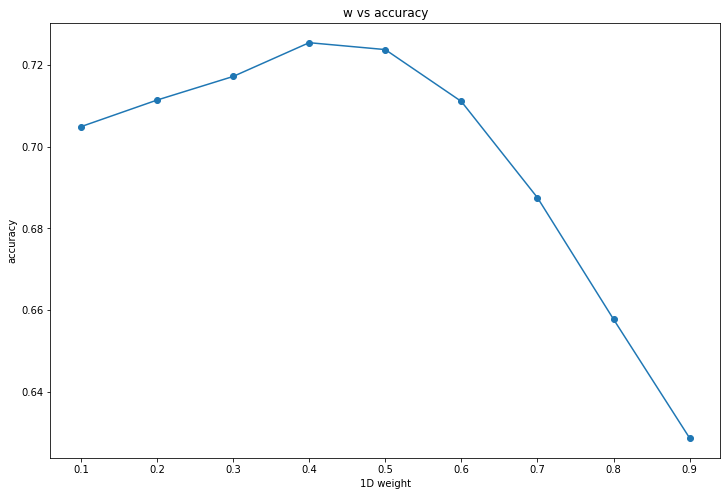

In [40]:
# w vs accuracy
plt.rcParams["figure.figsize"] = (12, 8)  # defaults: [6.0, 4.0]
plt.plot(list(w_acc.keys()), [np.mean(a) for a in w_acc.values()], marker="o")
plt.xlabel("1D weight")
plt.ylabel("accuracy")
plt.title("w vs accuracy")
plt.show()


In [34]:
# final ensemble accuracies with chosen w1 value
w1 = 0.4
fa = []
for val_idx, ((y_pred1, y_pred2), y_test) in enumerate(zip(predictions, tests)):
    y_pred = (w1 * y_pred1) + ((1 - w1) * y_pred2)

    cl = fold_chunk_lens[val_idx]
    y_pred_agg = sum_rule_agg(y_pred, cl)
    y_test_agg = sum_rule_agg(y_test, cl)

    acc = (y_pred_agg == y_test_agg).sum() / len(y_pred_agg)
    print(f"fold={val_idx}, acc={acc}")
    fa.append(acc)


fold=0, acc=0.7189384800965019
fold=1, acc=0.7304878048780488
fold=2, acc=0.5661016949152542
fold=3, acc=0.7367864693446089
fold=4, acc=0.8031674208144797
fold=5, acc=0.748062015503876
fold=6, acc=0.6571072319201995
fold=7, acc=0.7579787234042553
fold=8, acc=0.7538461538461538
fold=9, acc=0.7820672478206725


In [35]:
# average accuracy and stddev
np.mean(fa), np.std(fa)


(0.725454324254405, 0.06471490083079626)

In [20]:
# testing ensemble model (1d+VGG-fine-tuned 2d)
accuracies = []
confusion_matrices = []
predictions = []
tests = []
for val_idx in range(10):
    print(f"Starting loop with val_idx={val_idx}")
    X_test, y_test, cl = fold_Xs[val_idx], fold_ys[val_idx], fold_chunk_lens[val_idx]

    copy_to_train_test_dir(test_fold=val_idx + 1, test_only=True)
    val_datagen = ImageDataGenerator(rescale=1.0 / 255)
    validation_generator = val_datagen.flow_from_directory(
        TEST_DIR,
        # target_size=(IMG_HEIGHT, IMG_WIDTH),
        # target_size=(224, 224),
        target_size=(72, 72),
        batch_size=BATCH_SIZE,
        shuffle=False,
    )

    idxarr = np.array(
        [
            int(fn.split("/fold")[1].split(".jpg")[0].split("-")[1])
            for fn in validation_generator.filenames
        ]
    )

    # load the model with the best weights
    model1 = load_model(f"{MODEL_FILE}Vi{val_idx}")
    model2 = load_model(f"{VGG_MODEL_FILE}Vi{val_idx}")

    y_pred1 = model1.predict(X_test)
    y_pred2 = model2.predict(validation_generator)
    y_pred2 = reorder_2d_results(y_pred2, idxarr, cl)

    predictions.append((y_pred1, y_pred2))
    tests.append(y_test)
    y_pred = y_pred1 + y_pred2

    y_test_gen = to_categorical(validation_generator.classes, num_classes=NUM_CLASSES)
    y_test_reorder = reorder_2d_results(y_test_gen, idxarr, cl)

    y_pred_agg1 = sum_rule_agg(y_pred1, cl)
    y_pred_agg2 = sum_rule_agg(y_pred2, cl)

    y_pred_agg = sum_rule_agg(y_pred, cl)
    y_test_agg = sum_rule_agg(y_test_reorder, cl)

    acc1 = (y_pred_agg1 == y_test_agg).sum() / len(y_pred_agg)
    acc2 = (y_pred_agg2 == y_test_agg).sum() / len(y_pred_agg)

    acc = (y_pred_agg == y_test_agg).sum() / len(y_pred_agg)

    accuracies.append((acc, acc1, acc2))
    print(f"ensemble={acc}, 1d={acc1}, 2d={acc2}")

    cm = confusion_matrix(y_test_agg, y_pred_agg, num_classes=NUM_CLASSES)
    confusion_matrices.append(cm)


Starting loop with val_idx=0
Found 10047 images belonging to 10 classes.
ensemble=0.7141133896260555, 1d=0.623642943305187, 2d=0.6803377563329313
Starting loop with val_idx=1
Found 9936 images belonging to 10 classes.
ensemble=0.7024390243902439, 1d=0.6048780487804878, 2d=0.7182926829268292
Starting loop with val_idx=2
Found 10809 images belonging to 10 classes.
ensemble=0.6282485875706215, 1d=0.45084745762711864, 2d=0.63954802259887
Starting loop with val_idx=3
Found 11131 images belonging to 10 classes.
ensemble=0.7610993657505285, 1d=0.6374207188160677, 2d=0.6966173361522199
Starting loop with val_idx=4
Found 10468 images belonging to 10 classes.
ensemble=0.8393665158371041, 1d=0.7081447963800905, 2d=0.8042986425339367
Starting loop with val_idx=5
Found 9368 images belonging to 10 classes.
ensemble=0.7558139534883721, 1d=0.6201550387596899, 2d=0.7299741602067183
Starting loop with val_idx=6
Found 9738 images belonging to 10 classes.
ensemble=0.71571072319202, 1d=0.6084788029925187, 

In [21]:
accuracies

[(0.7141133896260555, 0.623642943305187, 0.6803377563329313),
 (0.7024390243902439, 0.6048780487804878, 0.7182926829268292),
 (0.6282485875706215, 0.45084745762711864, 0.63954802259887),
 (0.7610993657505285, 0.6374207188160677, 0.6966173361522199),
 (0.8393665158371041, 0.7081447963800905, 0.8042986425339367),
 (0.7558139534883721, 0.6201550387596899, 0.7299741602067183),
 (0.71571072319202, 0.6084788029925187, 0.7182044887780549),
 (0.660904255319149, 0.5212765957446809, 0.7433510638297872),
 (0.7987179487179488, 0.6948717948717948, 0.767948717948718),
 (0.8194271481942715, 0.6288916562889165, 0.8244084682440846)]

In [22]:
# finding best value of w1
w_acc = {w1: [] for w1 in np.linspace(0.1, 0.9, 9)}
for val_idx, ((y_pred1, y_pred2), y_test) in enumerate(zip(predictions, tests)):
    max_acc, max_w1 = -1, -1
    for w1 in np.linspace(0.1, 0.9, 9):
        y_pred = (w1 * y_pred1) + ((1 - w1) * y_pred2)

        cl = fold_chunk_lens[val_idx]
        y_pred_agg = sum_rule_agg(y_pred, cl)
        y_test_agg = sum_rule_agg(y_test, cl)

        acc = (y_pred_agg == y_test_agg).sum() / len(y_pred_agg)
        w_acc[w1].append(acc)
        if acc > max_acc:
            max_acc, max_w1 = acc, w1
    print(f"fold={val_idx}, max_w1={max_w1}, max_acc={max_acc}")

fold=0, max_w1=0.4, max_acc=0.7165259348612787
fold=1, max_w1=0.2, max_acc=0.7317073170731707
fold=2, max_w1=0.1, max_acc=0.6474576271186441
fold=3, max_w1=0.6, max_acc=0.7632135306553911
fold=4, max_w1=0.4, max_acc=0.8427601809954751
fold=5, max_w1=0.4, max_acc=0.7609819121447028
fold=6, max_w1=0.30000000000000004, max_acc=0.7381546134663342
fold=7, max_w1=0.1, max_acc=0.7446808510638298
fold=8, max_w1=0.4, max_acc=0.8076923076923077
fold=9, max_w1=0.4, max_acc=0.8268991282689913


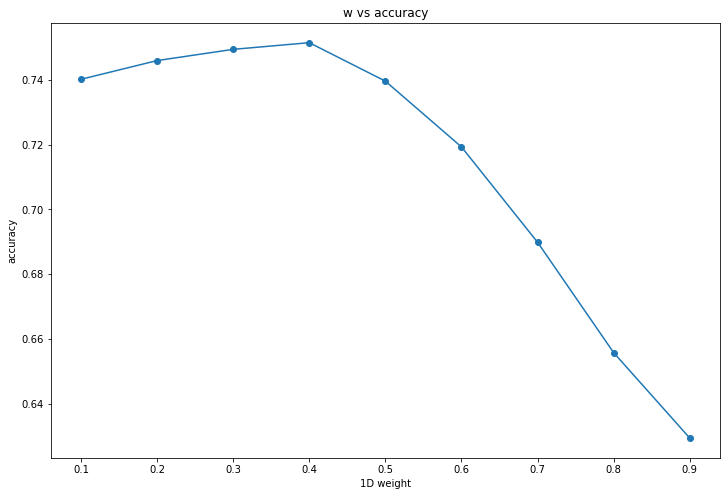

In [23]:
# w vs accuracy
plt.rcParams["figure.figsize"] = (12, 8)  # defaults: [6.0, 4.0]
plt.plot(list(w_acc.keys()), [np.mean(a) for a in w_acc.values()], marker="o")
plt.xlabel("1D weight")
plt.ylabel("accuracy")
plt.title("w vs accuracy")
plt.show()


In [24]:
# final ensemble accuracies with chosen w1 value
w1 = 0.4
fa = []
for val_idx, ((y_pred1, y_pred2), y_test) in enumerate(zip(predictions, tests)):
    y_pred = (w1 * y_pred1) + ((1 - w1) * y_pred2)

    cl = fold_chunk_lens[val_idx]
    y_pred_agg = sum_rule_agg(y_pred, cl)
    y_test_agg = sum_rule_agg(y_test, cl)

    acc = (y_pred_agg == y_test_agg).sum() / len(y_pred_agg)
    print(f"fold={val_idx}, acc={acc}")
    fa.append(acc)


fold=0, acc=0.7165259348612787
fold=1, acc=0.7219512195121951
fold=2, acc=0.6463276836158192
fold=3, acc=0.7452431289640592
fold=4, acc=0.8427601809954751
fold=5, acc=0.7609819121447028
fold=6, acc=0.729426433915212
fold=7, acc=0.7167553191489362
fold=8, acc=0.8076923076923077
fold=9, acc=0.8268991282689913


In [25]:
# average accuracy and stddev
np.mean(fa), np.std(fa)


(0.7514563249118976, 0.05670275795954261)